# Optimize input pipeline performances
The `tf.data` API includes flexible tools to build performant input pipelines. This is crucial when working with accellerators where the aim is to reduce their idle time spent waiting for data.

The code in the notebook is a slight modification of the code available in the [official guide](https://www.tensorflow.org/guide/data_performance).

In [1]:
import tensorflow as tf
import numpy as np
from time import time, sleep
import matplotlib.pyplot as plt

In [2]:
# Custom Dataset: similar to Dataset.range but with fixed 
# time delays to simulate file opening and record reading
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # Opening the file
        sleep(0.3)
        
        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            sleep(0.2)
            
            yield (sample_idx,)
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.int64,
            output_shapes=(1,),
            args=(num_samples,)
        )

In [3]:
def benchmark(dataset, num_epochs=1):
    start_time = time()
    times = [start_time]
    
    for epoch_num in range(num_epochs):
        epoch_start = time()
        for sample in dataset:
            # Performing a training step
            sleep(0.1)
            
            times.append(time())
            tf.print("Step time:\t%.2f"%(times[-1] - times[-2]))
                
        tf.print("Epoch end:\t%.2f"%(time() - epoch_start))    
        
    tf.print("Total time:\t%.2f"%(time() - start_time))
    plt.bar(np.arange(len(times)-1),np.diff(times))
    plt.xlabel("Step")
    plt.xticks(np.arange(len(times)-1))

Step time:	0.61
Step time:	0.31
Step time:	0.30
Epoch end:	1.23
Total time:	1.23


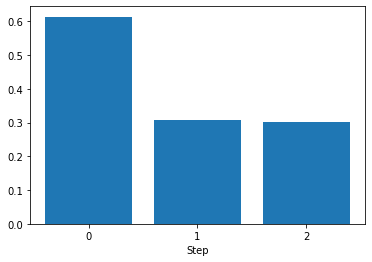

In [4]:
benchmark(
    ArtificialDataset()
)

![naive](https://www.tensorflow.org/guide/images/data_performance/naive.svg)

# Prefetch

Step time:	0.62
Step time:	0.20
Step time:	0.21
Epoch end:	1.03
Total time:	1.03


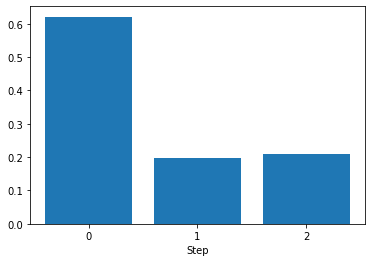

In [5]:
benchmark(
    ArtificialDataset().prefetch(1)
)

![prefetched~](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)

## Interleave
In what follows we will simulate a scenario where the data come from 2 files. As baseline reference consider iterating through the artificial dataset 2 times.

Step time:	0.62
Step time:	0.31
Step time:	0.31
Epoch end:	1.26
Step time:	0.65
Step time:	0.31
Step time:	0.31
Epoch end:	1.24
Total time:	2.51


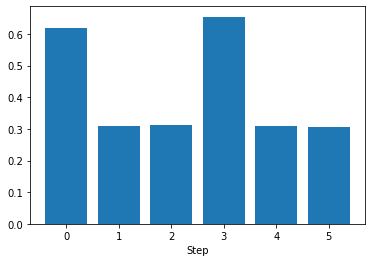

In [6]:
benchmark(ArtificialDataset(), num_epochs=2)

Step time:	0.62
Step time:	0.62
Step time:	0.30
Step time:	0.30
Step time:	0.30
Step time:	0.31
Epoch end:	2.45
Total time:	2.45


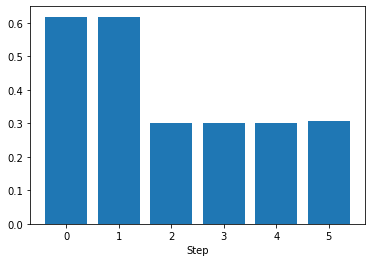

In [7]:
benchmark(
    tf.data.Dataset.range(2).interleave(lambda x: ArtificialDataset()),
    num_epochs=1)

![sequential_interleave](https://www.tensorflow.org/guide/images/data_performance/sequential_interleave.svg)

Step time:	0.62
Step time:	0.10
Step time:	0.10
Step time:	0.10
Step time:	0.10
Step time:	0.11
Epoch end:	1.15
Total time:	1.15


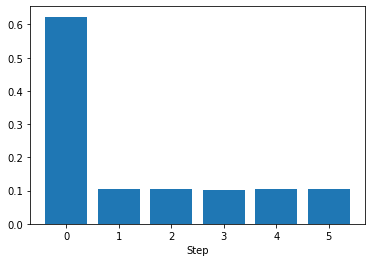

In [8]:
benchmark(
    tf.data.Dataset.range(2).interleave(lambda x: ArtificialDataset(),
                                        block_length=1,
                                        num_parallel_calls=2),
    num_epochs=1)

![parallel_interleave](https://www.tensorflow.org/guide/images/data_performance/parallel_interleave.svg)

## Data transformation
Now we will simulate some extra time delay caused by a preprocessing step in the input pipeline.

In [9]:
def mapped_function(s):
    # Do some hard pre-processing
    tf.py_function(lambda: sleep(0.3), [], ())
    return s

Step time:	0.92
Step time:	0.62
Step time:	0.61
Epoch end:	2.15
Total time:	2.15


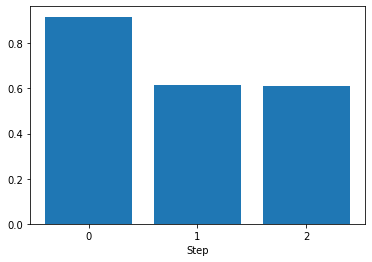

In [10]:
benchmark(ArtificialDataset().map(mapped_function))

![sequential_map](https://www.tensorflow.org/guide/images/data_performance/sequential_map.svg)

Step time:	0.92
Step time:	0.20
Step time:	0.21
Epoch end:	1.33
Total time:	1.33


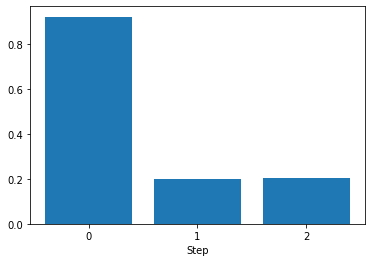

In [11]:
benchmark(ArtificialDataset().map(mapped_function, num_parallel_calls=3))

![parallel_map](https://www.tensorflow.org/guide/images/data_performance/parallel_map.svg)

## Caching
There could be transformations of the dataset that there is no need to repeat. In these casses the `Dataset.cache` transformation allows us to cache a dataset during the first epoch, either in memory or on local storage, and reuse the cached data in the following epochs.

Step time:	0.92
Step time:	0.61
Step time:	0.61
Epoch end:	2.15
Step time:	0.12
Step time:	0.10
Step time:	0.11
Epoch end:	0.33
Total time:	2.49


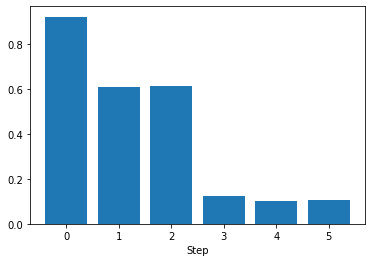

In [12]:
# cache after time consuming map!
benchmark(ArtificialDataset().map(mapped_function).cache(),2)

![cached_dataset](https://www.tensorflow.org/guide/images/data_performance/cached_dataset.svg)

## Vectorizing mapping

In [26]:
def vectorizable_map(x):
    return tf.ones(shape=(int(1e8),1), dtype=tf.int64)@tf.reshape(x,(1,-1))

Step time:	5.75
Epoch end:	5.75
Total time:	5.75


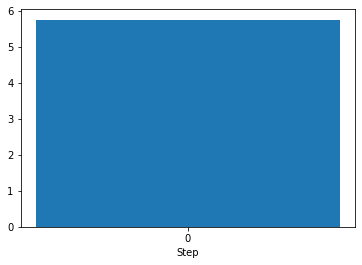

In [27]:
benchmark(
    ArtificialDataset().map(vectorizable_map).batch(3)
)

Step time:	2.59
Epoch end:	2.62
Total time:	2.62


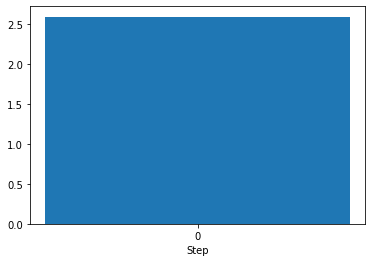

In [28]:
benchmark(
    ArtificialDataset().batch(3).map(vectorizable_map)
)